# LangGraph 101

[LLMs](https://python.langchain.com/docs/concepts/chat_models/) make it possible to embed intelligence into a new class of applications. [LangGraph](https://langchain-ai.github.io/langgraph/) is a framework to help build applications with LLMs. Here, we will overview the basics of LangGraph, explain its benefits, show how to use it to build workflows / agents, and show how it works with [LangChain](https://www.langchain.com/) / [LangSmith](https://docs.smith.langchain.com/).

![ecosystem](./img/ecosystem.png)

## Chat models

[Chat models](https://python.langchain.com/docs/concepts/chat_models/) are the foundation of LLM applications. They are typically accessed through a chat interface that takes a list of messages as input and returns a message as output. LangChain provides [a standardized interface for chat models](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html), making it easy to [access many different providers](https://python.langchain.com/docs/integrations/chat/).

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-4.1", temperature=0)

## Running the model

The `init_chat_model` interface provides [standardized](https://python.langchain.com/docs/concepts/runnables/) methods for using chat models, which include:
- `invoke()`: Synchronously process inputs and return outputs
- `stream()`: Return outputs [incrementally](https://python.langchain.com/docs/concepts/streaming/#stream-and-astream) as they're generated

In [ ]:
result = llm.invoke("What is LangGraph?")

In [ ]:
type(result)

In [ ]:
result

In [ ]:
result.content

## Tools

[Tools](https://python.langchain.com/docs/concepts/tools/) are utilities that can be called by a chat model. In LangChain, creating tools can be done using the `@tool` decorator, which transforms Python functions into callable tools. It will automatically infer the tool's name, description and expected arguments from the function definition. You can also use [Model Context Protocol (MCP) servers](https://github.com/langchain-ai/langchain-mcp-adapters) as LangChain-compatible tools. 

In [ ]:
from langchain.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

In [ ]:
type(write_email)

In [ ]:
write_email.args

In [ ]:
write_email.description

## Tool Calling

Tools can be [called](https://python.langchain.com/docs/concepts/tool_calling/) by LLMs. When a tool is bound to the model, the model can choose to call the tool by returning a structured output with tool arguments. We use the `bind_tools` method to augment an LLM with tools.

![tool-img](img/tool_call_detail.png)

Note that we use the [`tool_choice` parameter](https://python.langchain.com/docs/how_to/tool_choice/) to enforce tool calling.

In [ ]:
# Connect tools to a chat model
model_with_tools = llm.bind_tools([write_email], tool_choice="required")

# The model will now be able to call tools
output = model_with_tools.invoke("Draft a response to my boss about tomorrow's meeting")

In [ ]:
# Extract tool calls and execute them
args = output.tool_calls[0]['args']
args

In [ ]:
# Call the tool
result = write_email.invoke(args)
print(result)  # "Email to boss@company.com drafted with subject 'Re: Meeting Tomorrow'"

Above, we enforce tool calling by setting `tool_choice="required"`, so the model will always call a tool to write an email.

![basic_prompt](img/tool_call.png)

## Workflows
 
There are many patterns for building applications with LLMs. 

[We can embed LLM calls into pre-defined workflows](https://langchain-ai.github.io/langgraph/tutorials/workflows/), giving the system more agency to make decisions. 

As an example, we could add a router step to determine whether to write an email or not.

![workflow_example](img/workflow_example.png)

## Agents

We can further increase agency, allowing the LLM to dynamically direct its own tool usage. 

[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/) are typically implemented as tool calling in a loop, where the output of each tool call is used to inform the next action.

![agent_example](img/agent_example.png)

Agents are well suited to open-ended problems where it's difficult to predict the *exact* steps needed in advance.
 
Workflows are often appropriate when the control flow can easily be defined in advance. 

![workflow_v_agent](img/workflow_v_agent.png)

## What is LangGraph? 

[LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/) provides low-level supporting infrastructure that sits underneath *any* workflow or agent. 

It does not abstract prompts or architecture, and provides a few benefits:

- **Control**: Make it easy to define and / or combine agents and workflows.
- **Persistence**: Provide a way to persist the state of a graph, which enables both memory and human-in-the-loop.
- **Testing, Debugging, and Deployment**: Provide an easy onramp for testing, debugging, and deploying applications.

### Control

LangGraph lets you define your application as a graph with:

1. *State*: What information do we need to track over the course of the application?
2. *Nodes*: How do we want to update this information over the course of the application?
3. *Edges*: How do we want to connect these nodes together?

We can use the [`StateGraph` class](https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs) to initialize a LangGraph graph with a [`State` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

`State` defines the schema for information we want to track over the course of the application. 

This can be any object with `getattr()` in python, such as a dictionary, dataclass, or Pydantic object. 

In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class StateSchema(TypedDict):
    request: str
    email: str

workflow = StateGraph(StateSchema)

Each node is simply a python function or typescript function. This gives us full control over the logic inside each node.

They receive the current state, and return a dictionary to update the state.

By default, [state keys are overwritten](https://langchain-ai.github.io/langgraph/how-tos/state-reducers/). 

However, you can [define custom update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). 

![nodes_edges](img/nodes_edges.png)

In [ ]:
def write_email_node(state: StateSchema) -> StateSchema:
    # Imperative code that processes the request
    output = model_with_tools.invoke(state["request"])
    args = output.tool_calls[0]['args']
    email = write_email.invoke(args)
    return {"email": email}

Edges connect nodes together. 

We specify the control flow by adding edges and nodes to our state graph. 

In [ ]:
workflow = StateGraph(StateSchema)
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()

In [ ]:
app.invoke({"request": "Draft a response to my boss about tomorrow's meeting"})

Routing between nodes can be done [conditionally](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) using a simple function. 

The return value of this function is used as the name of the node (or list of nodes) to send the state to next. 

You can optionally provide a dictionary that maps the `should_continue` output to the name of the next node.

In [ ]:
from typing import Literal
from langgraph.graph import MessagesState
from email_assistant.utils import show_graph

def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""

    output = model_with_tools.invoke(state["messages"])
    return {"messages": [output]}

def run_tool(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["run_tool", END]:
    """Route to tool handler, or end if Done tool called"""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the last message is a tool call, check if it's a Done tool call
    if last_message.tool_calls:
        return "run_tool"
    # Otherwise, we stop (reply to the user)
    return END

workflow = StateGraph(MessagesState)
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges("call_llm", should_continue, {"run_tool": "run_tool", END: END})
workflow.add_edge("run_tool", END)

# Run the workflow
app = workflow.compile()

show_graph(app)

In [ ]:
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my boss about tomorrow's meeting"}]})
result["messages"]

With these low level components, you can build many many different workflows and agents. See [this tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/)!

Because agents are such a common pattern, [LangGraph](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built) has [a pre-built agent](https://langchain-ai.github.io/langgraph/agents/overview/?ref=blog.langchain.dev#what-is-an-agent) abstraction.

With LangGraph's [pre-built method](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built), we just pass in the LLM, tools, and prompt. 

In [ ]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided."  
)

# Run the agent
agent.invoke(
    {"messages": [{"role": "user", "content": "Draft a response to my boss about tomorrow's meeting"}]}
)

### Persistence

#### Threads

It can be very useful to allow agents to pause and gather human feedback.

LangGraph has a built-in persistence layer, implemented through checkpointers, to enable this. 

When you compile graph with a checkpointer, the checkpointer saves a [checkpoint](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints) of the graph state at every step. 

Checkpoints are saved to a thread, which can be accessed after graph execution.

![checkpointer](img/checkpoints.png)


In [ ]:
from langgraph.checkpoint.memory import InMemorySaver

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided.",
    checkpointer=InMemorySaver()
)

config = {"configurable": {"thread_id": "1"}}
result = agent.invoke({"messages": [{"role": "user", "content": "What are some good practices for writing emails?"}]}, config)
                    

In [ ]:
# Get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
state = agent.get_state(config)
for message in state.values['messages']:
    message.pretty_print()

In [ ]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "Good, let's use lesson 3 to craft a response to my boss about tomorrow's meeting"}]}, config)
for m in result['messages']:
    m.pretty_print()

In [ ]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "I like this, let's write the email"}]}, config)
for m in result['messages']:
    m.pretty_print()

#### Interrupts

In LangGraph, we can use [interrupts](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/) to stop graph execution to collect input from a user and continue execution with collected input.

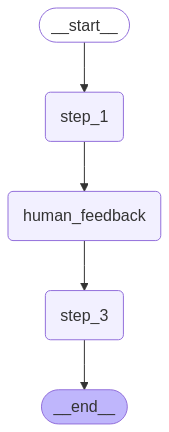

In [25]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)
show_graph(graph)

In [26]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback:', resumable=True, ns=['human_feedback:67ddf84d-b095-783a-013c-4eb4b56f07dc']),)}




To resume from an interrupt, we can use [the `Command` object](https://langchain-ai.github.io/langgraph/how-tos/command/). We'll use it to resume the graph from the interrupted state, passing the value to return from the interrupt call to `resume`. 

In [27]:
# Continue the graph execution
for event in graph.stream(
    Command(resume="go to step 3!"),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

---human_feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}




### Testing, Debugging, and Deployment

When we are using LangChain or LangGraph, LangSmith logging [will work out of the box](https://docs.smith.langchain.com/observability/how_to_guides/trace_with_langgraph) with the following environment variables set:

```
export LANGSMITH_TRACING=true
export LANGSMITH_API_KEY="<your-langsmith-api-key>"
```

In [ ]:
_set_env("LANGSMITH_TRACING")
_set_env("LANGSMITH_API_KEY")

Here is the LangSmith trace from above graph execution:

https://smith.langchain.com/public/6f77014f-d054-44ed-aa2c-8b06ceab689f/r

We can see that the agent is able to continue the conversation from the previous state because we used a checkpointer.

It's also easy to deploy to deploy our graph using [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/). 

We simply need to ensure our project has [a structure](https://langchain-ai.github.io/langgraph/concepts/application_structure/) like this:

```
my-app/
├── my_agent # all project code lies within here
│   └── agent.py # code for constructing your graph
├── .env # environment variables
├── langgraph.json  # configuration file for LangGraph
└── pyproject.toml # dependencies for your project
```

The `langgraph.json` file specifies the dependencies, graphs, environment variables, and other settings required to deploy a LangGraph application.

To test this, let's deploy `langgraph_101.py`. We have it in our `langgraph.json` file in this repo:

```
 "langgraph101": "./src/email_assistant/langgraph101.py:app",
```

There are a range of [deployment options](https://langchain-ai.github.io/langgraph/tutorials/deployment/). 

* All create an API [server](https://langchain-ai.github.io/langgraph/concepts/langgraph_server/) for our graph
* All include an interactive IDE (LangGraph [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/)).
 
We can start a deployment locally using `langgraph dev`, run this command in the root directory of the repo.

Here we can see a visualization of the graph as well as the graph state in Studio.

![langgraph_studio](img/langgraph_studio.png)